In [18]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfeager
from tensorflow.contrib.learn.python.learn import trainable
import tensorflow.contrib.eager as tensor_eager
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [5]:
def load_img_preprocess(image_path):
    img_str = tf.read_file(image_path)

    img_decode = tf.image.decode_jpeg(img_str, 3)

    img = tf.cast(img_decode, tf.float32)

    dim =512.0

    height = tf.to_float(tf.shape(img)[1])

    width = tf.to_float(tf.shape(img)[0])

    scale = tf.cond(tf.greater(height, width), lambda: dim/width, lambda: dim/height)

    newHeight = tf.to_int32(height * scale)
    newWidth = tf.to_int32(width * scale)

    img = tf.image.resize_images(img, [newHeight, newWidth])

    """VGG_MEAN = [123.68, 116.78, 103.94]  # This is R-G-B for Imagenet

    img = tf.random_crop(img, [224, 224, 3])
    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
    img = img - means
    """
    img = np.expand_dims(img, axis=0)

    VGG_MEAN = [123.68, 116.78, 103.94]

    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
    img = img - means

    return img

In [6]:

def deprocess_img(processed_img):
  x = processed_img
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x


def restore_image(processed_image):
    x = processed_image
    x = np.squeeze(x, 0)

    VGG_MEAN = [123.68, 116.78, 103.94]
    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
    x = x + means
    return x


In [7]:
def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))


In [8]:
def gram_matrix(input_tensor):

    # We make the image channels first
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


In [9]:
def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)



In [54]:
def run(content_path, style_path, itrNum, content_weight, style_weight):

    # get the images
    # tf.enable_eager_execution()

    content_image = load_img_preprocess(content_path)

    style_image = load_img_preprocess(style_path)

    """
    get the model from keras basically lets us extract the layers
    and their corresponding intermediate and batch outputs

    can do interesting things with the intermediate layers results

    """

    pretrained_net = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    pretrained_net.trainable = False

    style_layers = []

    for i in range(1, 5):
        style_layers.append('block{}_conv1'.format(i))

    content_out_layers = [pretrained_net.get_layer('block5_conv2').output]

    style_out_layers = []

    for layer_name in style_layers:
        style_out_layers.append(pretrained_net.get_layer(layer_name).output)

    model_out = content_out_layers + style_out_layers

    main_model = models.Model(pretrained_net.input, model_out)

    for layer in main_model.layers:
        layer.trainable = False

    style_features = [style_layer[0]
                      for style_layer in main_model(style_image)[:5]]
    content_features = [content_layer[0]
                        for content_layer in main_model(content_image)[5:]]

    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_img_preprocess(content_path)
    init_image = tensor_eager.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    loss_best = float('inf')
    best_img = None

    # clip the input image 
    # using max dim and min dim
    means = np.array([103.939, 116.779, 123.68])
    min_dim = -means
    max_dim = 255-means

    for i in range(itrNum):
        # compute loss for all layers
        # compute style loss 
        # compute content loss
        # compute their sum and produce gradients over the total loss
        # optimize using the total loss and the input image
        with tf.GradientTape() as gradi:
            out_final_entireImage = main_model(init_image)
            style_out = out_final_entireImage[:5]
            content_out = out_final_entireImage[5:]
            stylePoints = 0
            contentPoints = 0

            # equal weight across the contributions of all layers
            content_layer_norm = 1/float(5)
            for out, inter in zip(content_features, content_out):
                contentPoints= contentPoints + content_layer_norm*(tf.reduce_mean(tf.square(inter[0] - out)))

            
            style_layer_norm = 1/float(5)
            for out, inter in zip(gram_style_features, style_out):
                stylePoints = stylePoints + style_layer_norm*get_style_loss(inter[0],out)

            contentPoints = contentPoints*contentPoints
            stylePoints = stylePoints*stylePoints

            totalLoss = contentPoints + stylePoints

        gradients = gradi.gradient(totalLoss, init_image)
        opt.apply_gradients([(gradients,init_image)])

        clip_initImage = tf.clip_by_value(init_image, min_dim, max_dim)

        init_image.assign(clip_initImage)

        if(totalLoss<loss_best):
#             print('defeats the curr_loss')
            loss_best = totalLoss
            best_img = deprocess_img(init_image.numpy())
#             best_img = restore_image(init_image.numpy())
        
    plt.figure(figsize=(10,10))
    display_img = np.squeeze(best_img, axis=0)
    plt.imshow(display_img)
    plt.title('output image')
    plt.show()
    return best_img, loss_best


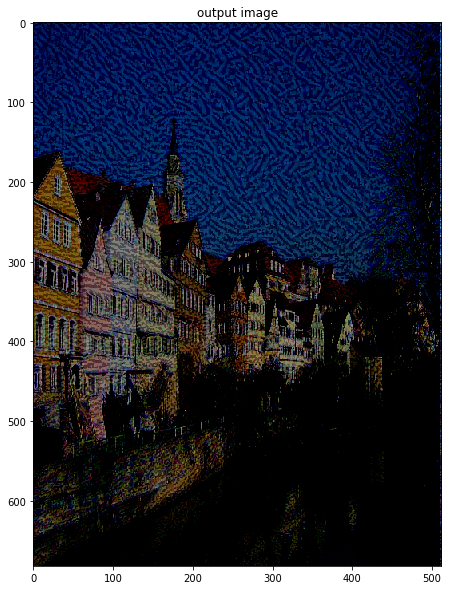

In [55]:

best_starry_night, best_loss = run('src_images/Tuebingen_Neckarfront.jpg','src_images/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', 10,1e3,1e-2)
